<a href="https://colab.research.google.com/github/louisechilds/ADS2002-Catheter/blob/main/Catheter_project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catheater project (Exploratory Data Analysis component)

Contributors:
Adam Choong
Louise Childs
Isaac Woods
Fengzhe Yang

The goal of this project is to determine whether CVC or NGT or ETT catheaters are "normally" placed or not. Hence, the approach taken will be a binary classificiation approach. We will be comparing neural network model configurations based on various metrics

In [2]:
import pandas as pd
import cv2
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
RS=42#set random seed consistent do not changeb

In [3]:
train=pd.read_csv('train.csv')
train_annots=pd.read_csv('train_annotations.csv')

In [4]:
train_annots.head(4)

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."


## Background

Features and terms in the dataset

* `ETT`: Endotrachael position describes the placement of the tube into the trachea that enables artificial ventilation. (assists with breathing)
* `NGT`: Nasogastric tube positioning describes the placement of the tube through the nostril to the back of the throat and passing through the oesophagus to the stomach. The nasogastric tube assists with feeding food into the digestive system.
* `CVC`: central venous catheater tube placement describes how the tube has been inserted into the heart through the inferior vena cava (a large vein). The purpose of the CVC tube is to pump drugs into circulation around the body.
* Swam Ganz Catheter: a thin tube that passes through the arteries in the heart to the lungs. This tube monitors the heart's blood flow and pressure.
* Normal placement: catheter is normally placed, no intervention needed
* Abnormal placement: catheter is misplaced. Possible intervention needed
* Borderline placement: cathether severely misplaced. Intervention needed

## Prelimary inspection of csvs
We must spot any missing values and decide what to do with them if we find them. Next we do some research on definitions for our variables and generate visual representations of our data

Since the entire dataset is too large and we need to be mindful of the RAM capacity, there needs to be a function in place to partially read a random sample of the dataset. We also need to organise the dataframes in such as way that it contains the images as the "feature variable" and the outcomes as the labels

In [5]:
#check missing values
train.isna().sum(),train_annots.isna().sum()

(StudyInstanceUID              0
 ETT - Abnormal                0
 ETT - Borderline              0
 ETT - Normal                  0
 NGT - Abnormal                0
 NGT - Borderline              0
 NGT - Incompletely Imaged     0
 NGT - Normal                  0
 CVC - Abnormal                0
 CVC - Borderline              0
 CVC - Normal                  0
 Swan Ganz Catheter Present    0
 PatientID                     0
 dtype: int64,
 StudyInstanceUID    0
 label               0
 data                0
 dtype: int64)

There are no missing values to impute in the training dataset. Now we complete standard exploratory data analysis and visualisation on the csv files:

In [6]:
total_pats=train['PatientID'].unique().shape[0]
print(f"There are {train['PatientID'].unique().shape[0]} patients being examined in the data")
print(f"There are {len(train_annots['StudyInstanceUID'].unique())} annotated X ray images")
print(f"There are {len(train['StudyInstanceUID'].unique())} X ray images")

There are 3255 patients being examined in the data
There are 9095 annotated X rays
There are 30083 X ray images


## Handling the csv files and directories
A handful of useful functions will be defined below. Their main purposes will be:
* Cleaning the dataframe so that it includes only the instances with one outcome and possibly one annotation for each catheter type
* Forming the appropriate directory structures for ResNet and DenseNet and other models
* Setting file labels on dataframes
* Reading images

In [7]:
def list_abs_paths_in_dir(directory):
  # Initialize an empty list to store the absolute paths to files
  file_paths = []
  # files=[]
  # Use os.walk() to traverse through the directory and its subdirectories
  for root, dirs, files in os.walk(directory):
      for file in files:
          # Construct the absolute path to the file
          file_path = os.path.abspath(os.path.join(root, file))

          # Append the absolute path to the list
          file_paths.append(file_path)
          # files.append(os.path.basename(file_path))
  return file_paths

def get_filenames_of_abs_paths(absfiles):
  '''
  can only pass after listing absolute paths
  '''
  basefiles=[]
  for i in absfiles:
    basefiles.append(os.path.basename(i))
  return basefiles

In [8]:
def set_files_on_dataframe(df,tag='StudyInstanceUID'):
  '''
  df: target data frame
  tag: StudyInstanceUID
  '''
  if 'image_file' not in df.columns:
    df['image_file']=''
  for i,row in df.iterrows():
    if '.jpg' not in row[tag]:
      path=row[tag]+'.jpg'
      df._set_value(i,'image_file',path)
    elif '.jpg' in row[tag]:
      path=row[tag]
      df._set_value(i,'image_file',path)
  return df

In [9]:
def clean_dataframe(df,cath_type):
    '''
    only runs for train, not train annotations
    '''
    if cath_type == 'CVC' or cath_type == 'ETT':
        dataframe=df[['StudyInstanceUID',cath_type+' - Abnormal',cath_type+' - Normal',cath_type+' - Borderline','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 0) & (dataframe[cath_type+' - Normal'] == 0) & (dataframe[cath_type+' - Borderline'] == 0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Borderline'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Borderline'] == 1)].index)
    elif cath_type == 'NGT':
        dataframe=df[['StudyInstanceUID','NGT - Abnormal','NGT - Normal','NGT - Borderline','NGT - Incompletely Imaged','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 0) & (dataframe['NGT - Normal'] == 0) & (dataframe['NGT - Borderline'] == 0) & (dataframe['NGT - Incompletely Imaged']==0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Incompletely Imaged']==1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Borderline'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Borderline'] == 1)].index)
    return dataframe

In [10]:
def image_reader(directory,file_name):
  path=directory+'/'+file_name
  img=cv2.imread(path)
  img=cv2.resize(img,dsize=(32,32))
  return img

In [11]:
def set_image_on_df(df,dir):
    '''
    works as long as there is a StudyInstanceUID column
    '''
    df['image']=''
    for i in range(0,len(df)):
        image=image_reader(dir,df.iloc[i]['image_file'])
        image=image.astype('float')
        df.at[i, 'image'] = image
    return df

In [12]:
train=set_files_on_dataframe(train)
ett=clean_dataframe(train,'ETT')
cvc=clean_dataframe(train,'CVC')
ngt=clean_dataframe(train,'NGT')

## Reading the data
We need to manipulate our dataset so it fulfils the mentioned criteria
* Multiclassification or binary classificaiton
* Relevant images only considered
* Feature extraction (highlighting annotations to increase pixel intensity)
* Well balanced variations

We will be using all images first but extending scalability will involve using only annotations


In [13]:
train_annots=set_files_on_dataframe(train_annots)

In [14]:
#source: https://www.kaggle.com/code/ihelon/catheter-position-exploratory-data-analysis?fbclid=IwAR1rhwS0ZMuVUkkUQMeP6TumSQFzpHMhypeCjb0IuVJcHCWVHtYVaKpwOjA
def plot_image_with_annotations(row_ind,df_annot,BASE_DIR):
    row = df_annot.iloc[row_ind]
    image_path = BASE_DIR+ "/"+row["StudyInstanceUID"] + ".jpg"
    label = row["label"]
    data = np.array(ast.literal_eval(row["data"]))
    plt.figure(figsize=(10, 5))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.scatter(data[:, 0], data[:, 1])
    plt.suptitle(label, fontsize=15)
    fig=plt.figure()
    return fig

def visualize_annotations(file_id,BASE_DIR,df_annot):
    plt.figure(figsize=(8, 8))
    image = cv2.imread(BASE_DIR+ "/"+file_id+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    df_patient = df_annot.loc[df_annot["StudyInstanceUID"] == file_id]

    if df_patient.shape[0]:
        labels = df_patient["label"].values.tolist()
        lines = df_patient["data"].apply(ast.literal_eval).values.tolist()

        for line, label in zip(lines, labels):
            line = np.asarray(line)
            plt.scatter(line[:, 0], line[:, 1], s=40, label=label)

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size': 20})

    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.show()



## EDA and Visualisation
We will be visualising the images, their annotations and the proportions of each type of image to assess their bias and imbalance. We will also be commenting on the surface level statistics of the data.

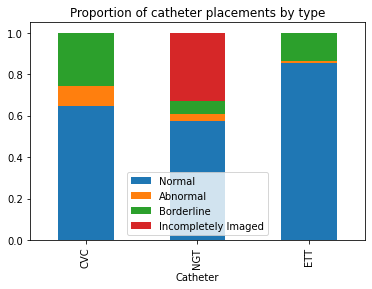

In [15]:
#assessment the degree of imbalance
sums=pd.DataFrame(train.sum()).T
sums=sums.drop(['StudyInstanceUID','PatientID','image_file','Swan Ganz Catheter Present'],axis=1)
cvc_n_total,cvc_a_total,cvc_b_total=sums.loc[0,'CVC - Normal'],sums.loc[0,'CVC - Abnormal'],sums.loc[0,'CVC - Borderline']
ett_n_total,ett_a_total,ett_b_total=sums.loc[0,'ETT - Normal'],sums.loc[0,'ETT - Abnormal'],sums.loc[0,'ETT - Borderline']
ngt_n_total,ngt_a_total,ngt_b_total,ngt_i_total=sums.loc[0,'NGT - Normal'],sums.loc[0,'NGT - Abnormal'],sums.loc[0,'NGT - Borderline'],sums.loc[0,'NGT - Incompletely Imaged']
graph_df=pd.DataFrame([['CVC',cvc_n_total,cvc_a_total,cvc_b_total,0], ['NGT',ngt_n_total,ngt_a_total,ngt_b_total,ngt_i_total], ['ETT',ett_n_total,ett_a_total,ett_b_total,0]],
                  columns=['Catheter', 'Normal', 'Abnormal', 'Borderline', 'Incompletely Imaged'])
graph_df.drop('Catheter',axis=1,inplace=True)
df_proportions = graph_df.div(graph_df.sum(axis=1), axis=0)
df_proportions['Catheter'] = ['CVC','NGT','ETT']
df_proportions.plot(x='Catheter', kind='bar', stacked=True,
       title='Proportion of catheter placements by type')
plt.show()

We can see that there are a substantial amount of incomplete images so perhaps, the NGT catheter is not a preferable catheter to analyse. As expected, most catheters have normal placements. We shall consider dropping incomplete images as they can cause our findings to be inaccurate. (not in a technical sense but in an intuitive sense) Other data visuals we will use include plotting annotations on images that have them to highlight catheter positions of abnromally, normally and borderline placed catheters for each type.

In [16]:
source='/projects/sc73/ranzcr-clip-catheter-line-classification/train'
cvc_annots_normal=train_annots[train_annots['label']=='CVC - Normal']
cvc_annots_normal.reset_index(inplace=True)
cvc_annots_normal.drop('index',axis=1,inplace=True)
cvc_annots_abnormal=train_annots[train_annots['label']=='CVC - Abnormal']
cvc_annots_abnormal.reset_index(inplace=True)
cvc_annots_abnormal.drop('index',axis=1,inplace=True)
cvc_annots_borderline=train_annots[train_annots['label']=='CVC - Borderline']
cvc_annots_borderline.reset_index(inplace=True)
cvc_annots_borderline.drop('index',axis=1,inplace=True)
ngt_annots_normal=train_annots[train_annots['label']=='NGT - Normal']
ngt_annots_normal.reset_index(inplace=True)
ngt_annots_normal.drop('index',axis=1,inplace=True)
ngt_annots_abnormal=train_annots[train_annots['label']=='NGT - Abnormal']
ngt_annots_abnormal.reset_index(inplace=True)
ngt_annots_abnormal.drop('index',axis=1,inplace=True)
ngt_annots_borderline=train_annots[train_annots['label']=='NGT - Borderline']
ngt_annots_borderline.reset_index(inplace=True)
ngt_annots_borderline.drop('index',axis=1,inplace=True)
ngt_annots_incomp=train_annots[train_annots['label']=='NGT - Incompletely Imaged']
ngt_annots_incomp.reset_index(inplace=True)
ngt_annots_incomp.drop('index',axis=1,inplace=True)
ett_annots_normal=train_annots[train_annots['label']=='ETT - Normal']
ett_annots_normal.reset_index(inplace=True)
ett_annots_normal.drop('index',axis=1,inplace=True)
ett_annots_abnormal=train_annots[train_annots['label']=='ETT - Abnormal']
ett_annots_abnormal.reset_index(inplace=True)
ett_annots_abnormal.drop('index',axis=1,inplace=True)
ett_annots_borderline=train_annots[train_annots['label']=='ETT - Borderline']
ett_annots_borderline.reset_index(inplace=True)
ett_annots_borderline.drop('index',axis=1,inplace=True)
sgp_annots=train_annots[train_annots['label']=='Swan Ganz Catheter Present']
sgp_annots.reset_index(inplace=True)
sgp_annots.drop('index',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
print(f'There are {len(cvc_annots_normal)} normal annotated placements for the CVC')
print(f'There are {len(cvc_annots_abnormal)} abnormal annotated placements for the CVC')
print(f'There are {len(cvc_annots_borderline)} borderline annotated placements for the CVC')
print(f'There are {len(ngt_annots_normal)} normal annotated placements for the NGT')
print(f'There are {len(ngt_annots_abnormal)} abnormal annotated placements for the NGT')
print(f'There are {len(ngt_annots_borderline)} borderline annotated placements for the NGT')
print(f'There are {len(ngt_annots_incomp)} incompletely imaged annotated NGT placements')
print(f'There are {len(ett_annots_normal)} normal annotated placements for the ETT')
print(f'There are {len(ett_annots_abnormal)} abnormal annotated placements for the ETT')
print(f'There are {len(ett_annots_borderline)} borderline annotated placements for the ETT')
print(f'There are {len(sgp_annots)} Swans Ganz annotated placements')


There are 7437 normal annotated placements for the CVC
There are 1206 abnormal annotated placements for the CVC
There are 2986 borderline annotated placements for the CVC
There are 1870 normal annotated placements for the NGT
There are 111 abnormal annotated placements for the NGT
There are 219 borderline annotated placements for the NGT
There are 1019 incompletely imaged NGT placements
There are 2536 normal annotated placements for the ETT
There are 30 abnormal annotated placements for the ETT
There are 428 borderline annotated placements for the ETT
There are 157 Swans Ganz annotated placements


Let's see the differences between normal, abnormal and borderline placements for each catheter. We will see that there is a clear indicator of what makes a catheter placement normal, abnormal or borderline. We will also see some common traits of what makes an image incomplete.

<Figure size 432x288 with 0 Axes>

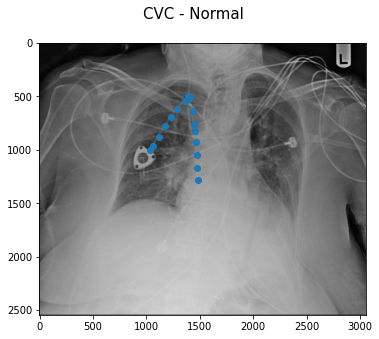

<Figure size 432x288 with 0 Axes>

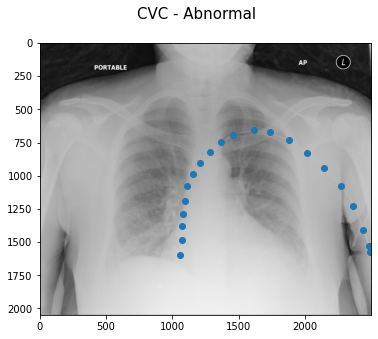

<Figure size 432x288 with 0 Axes>

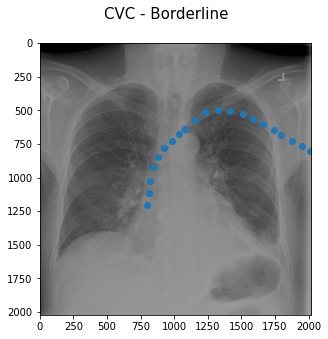

<Figure size 432x288 with 0 Axes>

In [16]:
#CVC
plot_image_with_annotations(row_ind=0,df_annot=cvc_annots_normal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=cvc_annots_abnormal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=cvc_annots_borderline,BASE_DIR=source)

<Figure size 432x288 with 0 Axes>

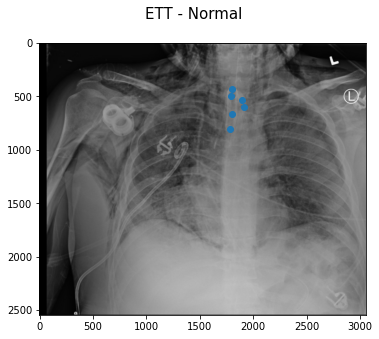

<Figure size 432x288 with 0 Axes>

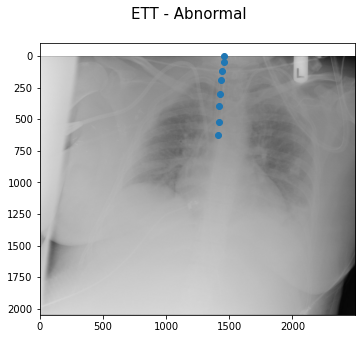

<Figure size 432x288 with 0 Axes>

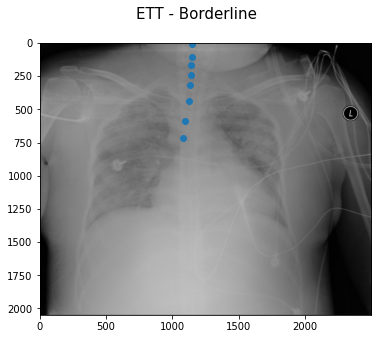

<Figure size 432x288 with 0 Axes>

In [17]:
#ETT
plot_image_with_annotations(row_ind=0,df_annot=ett_annots_normal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=ett_annots_abnormal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=ett_annots_borderline,BASE_DIR=source)

<Figure size 432x288 with 0 Axes>

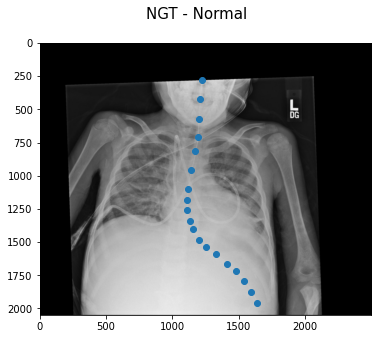

<Figure size 432x288 with 0 Axes>

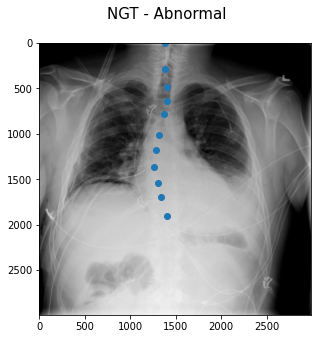

<Figure size 432x288 with 0 Axes>

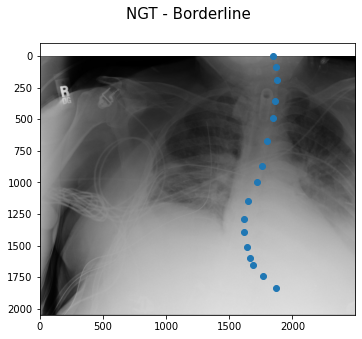

<Figure size 432x288 with 0 Axes>

In [18]:
#NGT
plot_image_with_annotations(row_ind=50,df_annot=ngt_annots_normal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=ngt_annots_abnormal,BASE_DIR=source)
plot_image_with_annotations(row_ind=0,df_annot=ngt_annots_borderline,BASE_DIR=source)

<Figure size 432x288 with 0 Axes>

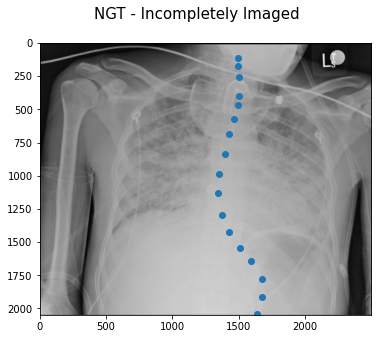

<Figure size 432x288 with 0 Axes>

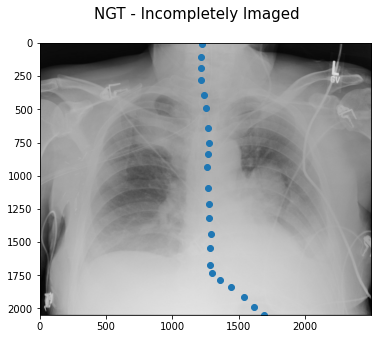

<Figure size 432x288 with 0 Axes>

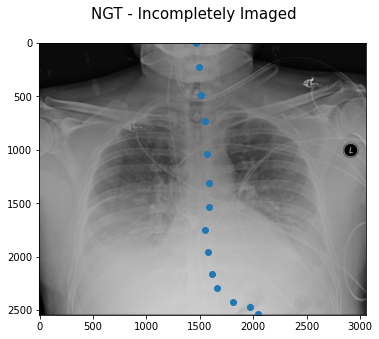

<Figure size 432x288 with 0 Axes>

In [19]:
#Incompletely imaged
plot_image_with_annotations(row_ind=0,df_annot=ngt_annots_incomp,BASE_DIR=source)
plot_image_with_annotations(row_ind=1,df_annot=ngt_annots_incomp,BASE_DIR=source)
plot_image_with_annotations(row_ind=2,df_annot=ngt_annots_incomp,BASE_DIR=source)

<Figure size 432x288 with 0 Axes>

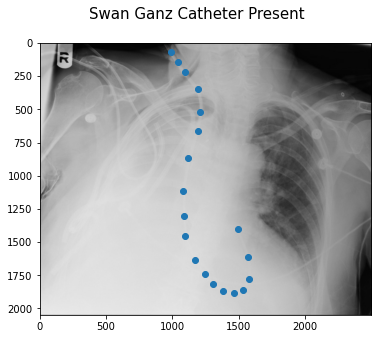

<Figure size 432x288 with 0 Axes>

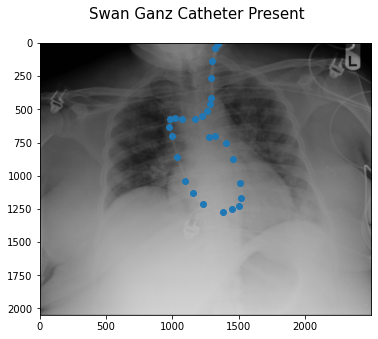

<Figure size 432x288 with 0 Axes>

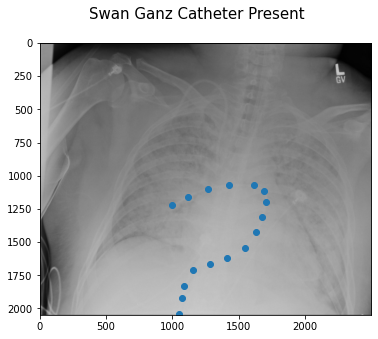

<Figure size 432x288 with 0 Axes>

In [20]:
#Swan Ganz catheter
plot_image_with_annotations(row_ind=0,df_annot=sgp_annots,BASE_DIR=source)
plot_image_with_annotations(row_ind=1,df_annot=sgp_annots,BASE_DIR=source)
plot_image_with_annotations(row_ind=2,df_annot=sgp_annots,BASE_DIR=source)

The main characteristic that differentiates CVC catheter placements seems to be the curvature and the protrusion of the tube particularly towards the neck area. In the images shown, borderline placements seem to describe catheters that have protruded the wrong area. Abnormal placements seem to allude to partially correct positionings. This may mean that the catheter correctly covers the veins but around the heart, the catheter may not be correctly placed. Normal placements have been correctly connected from the heart to the veins to the left arm. These differences seem to corroborate with our external research which states that CVC catheters are connected from the heart and pump drugs through the veins. So these issues can realistically occur.

It seems that the distinguishing characteristic between normally, abnormally and borderline placed ETT catheters is the depth at which they are placed. Normal catheter placements barely stick through the throat area into the lungs, while abnormal placements have slightly deeper protrusions and borderline placements have deeper protrusions as well as a more rigid placement. (the neck is curved but the catheter is inserted straight)

The difference between the normal catheter placement of the NGT and the borderline placement seems to be associated with how well the catheter placement is able to penetrate the stomach. If the placement is borderline, it would be safe to assume that it barely penetrates the stomach. If the catheter placement is abnormal, then the catheter does not even reach the stomach region. These differentiating characteristics are expected because our findings indicate that NGT catheters are supposed to deliver nutrients to the digestive system so they must reach the stomach and penetrate it enough for nutrients to be absorbed but the characteristics of borderline and abnormal placements prevent this. The common characteristic of incomplete images is that they fail to capture the depth at which the catheter penetrates the stomach.

For later purposes in assessing data quality and readiness for neural network fitting, we can assess the dimensions of different images. The main images we will be considering are those which have already been split. The conclusion made by this assessment therefore hold the assumption that the sample distribution reflects the population of images

In [21]:
def add_feature(df):
  '''
  must reset index
  '''
  df.reset_index(drop=True,inplace=True)
  if 'image' not in df.columns:
    df['image']=''
  for i, row in df.iterrows():
    feature = cv2.imread(os.path.join(source,row['image_file']), cv2.IMREAD_GRAYSCALE)
    df._set_value(i,'image',feature)
  return df

In [22]:
paths=list_abs_paths_in_dir('images_split')+list_abs_paths_in_dir('images_split')
files=get_filenames_of_abs_paths(paths)
sample_data={'file path':paths,'image_file':files}
sample_abs_df_tv=pd.DataFrame(sample_data)
sample_abs_df_tv.sort_values(by=['image_file'],inplace=True)
sample_annots_tv=train_annots[train_annots['image_file'].isin(sample_abs_df_tv['image_file'].tolist())]
sample_annots_tv.sort_values(by=['image_file'],inplace=True)
sample_annots_tv.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
shape_df=add_feature(sample_annots_tv)
row=[]
col=[]
for image in shape_df['image'].tolist():
    row.append(image.shape[0])
    col.append(image.shape[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0.5, 1.0, 'Column dimensions')

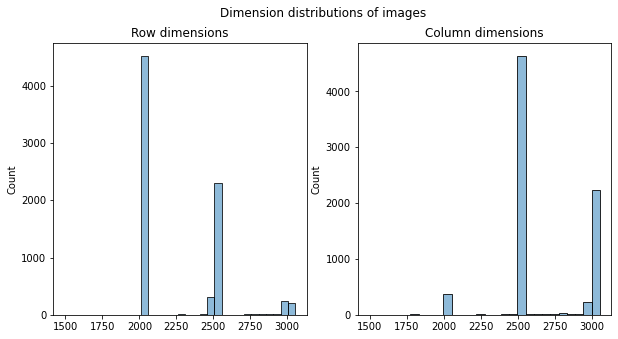

In [24]:
import seaborn as sns
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(10, 5))
rowdims=pd.DataFrame({"row dimensions":row})
coldims=pd.DataFrame({'column dimensions':col})
rowdist=sns.histplot(rowdims,ax=axes[0],legend=False)
coldist=sns.histplot(coldims,ax=axes[1],legend=False)
figure.suptitle('Dimension distributions of images')
axes[0].set_title('Row dimensions')
axes[1].set_title('Column dimensions')

We see that the most common row and column dimensions are approximately 2000 and 2500 pixels by a significant margin. Note that we cannot assume standardisation of all images to this size since row and column diemnsions are indpendent distributions.